In [1]:
import os
import sys
import numpy as np
from PIL import Image
import _pickle as pkl
import torch
from torchvision import transforms
from multiprocessing import dummy as mp
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
%matplotlib inline

Read the tissue vs white dataset.

In [2]:
dataset = pkl.load(open('/export/medical_ai/ucsf/whitespace_classification/tissue_vs_white_dataset.pkl', 'rb'))
X_data, y_data = dataset['X'] / 255., dataset['y']

Read list of all patches

In [4]:
head_dir = '/export/medical_ai/ucsf'
studies = ['RTOG-9413', 'RTOG-9202', 'RTOG-9408']
patch_list = []
for study in studies:
    print(study)
    slides_dir = os.path.join(head_dir, study, 'patches/patches_256_patchsize_224_resize_0_overlap_3_level')
    for slide in tqdm(os.listdir(slides_dir)):
        patch_list.extend([os.path.join(slides_dir, slide, i) for i in os.listdir(os.path.join(slides_dir, slide))])
patch_list = np.array(patch_list)

Loading pretrained model

In [5]:
import torchvision.models as models
device = 'cuda'
resnet18 = models.resnet18(pretrained=True)
resnet18 = torch.nn.DataParallel(resnet18).cuda()
resnet18.eval()

DataParallel(
  (module): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

Extracting the pre-softmax layer features of the images

In [6]:
batch_size = 1024
img_mean = np.reshape([0.485, 0.456, 0.406], [1, 1, 1, 3])
img_std = np.reshape([0.229, 0.224, 0.225], [1, 1, 1, 3])

In [7]:
representations = []
for i in range(int(np.ceil(len(X_data) / batch_size))):
    inp = (X_data[i*batch_size: (i+1)*batch_size] - img_mean) / img_std
    inp = torch.Tensor(inp.transpose([0, 3, 1, 2])).to(device)
    representation = resnet18(inp)
    representations.append(representation.cpu().detach().numpy())
representations = np.concatenate(representations)

Training a logistic regression model on top of the pretained model's representation.

In [8]:
lr = LogisticRegression(penalty='elasticnet', l1_ratio=0.1, C=10**(-2.5), solver='saga', max_iter=1000)
lr.fit(representations[:1500], y_data[:1500])
print('Test accuracy = {0:.2f}%'.format(100 * lr.score(representations[1500:], y_data[1500:])))
test_probs = lr.predict_proba(representations[1500:])[np.arange(len(representations[1500:])), y_data[1500:]]

Test accuracy = 97.83%


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Visualizing the mistakes

<Figure size 432x288 with 0 Axes>

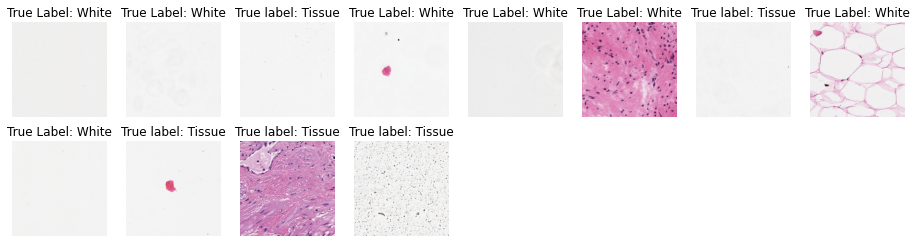

In [9]:
plt.suptitle('Classifier mistakes')
num_mistakes = np.sum(test_probs<0.5)
fig = plt.figure(figsize=(16, int(np.ceil(num_mistakes / 8)) * 2))
for i in range(np.sum(test_probs<0.5)):
    plt.subplot(int(np.ceil(num_mistakes / 8)), 8, i+1)
    plt.imshow(X_data[1000 + np.argsort(test_probs)[i]])
    plt.title('True label: Tissue' if y_data[1000 + i] else 'True Label: White')
    plt.axis('off')

Fitting on the whole dataset

In [10]:
lr.fit(representations, y_data)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression(C=0.0031622776601683794, l1_ratio=0.1, max_iter=1000,
                   penalty='elasticnet', solver='saga')

In [16]:
patches

array(['/export/medical_ai/ucsf/RTOG-9413/patches/patches_256_patchsize_224_resize_0_overlap_3_level/96172/96172_10_74_ws.png',
       '/export/medical_ai/ucsf/RTOG-9413/patches/patches_256_patchsize_224_resize_0_overlap_3_level/96172/96172_88_32_.png',
       '/export/medical_ai/ucsf/RTOG-9413/patches/patches_256_patchsize_224_resize_0_overlap_3_level/96172/96172_102_68_ws.png',
       ...,
       '/export/medical_ai/ucsf/RTOG-9413/patches/patches_256_patchsize_224_resize_0_overlap_3_level/96172/96172_62_48_.png',
       '/export/medical_ai/ucsf/RTOG-9413/patches/patches_256_patchsize_224_resize_0_overlap_3_level/96172/96172_64_67_ws.png',
       '/export/medical_ai/ucsf/RTOG-9413/patches/patches_256_patchsize_224_resize_0_overlap_3_level/96172/96172_101_31_.png'],
      dtype='<U120')

In [ ]:
pool = mp.Pool(32)
y_hat = []
patch_paths = []
tissue_hashtable = {}
for i in tqdm(range(int(np.ceil(len(patch_list) / batch_size)))):
    patches = patch_list[i*batch_size: (i+1) * batch_size]
    X = np.array(pool.map(lambda i: np.array(Image.open(i)) / 255., patches))
    inp = (X - img_mean) / img_std
    inp = torch.Tensor(inp.transpose([0, 3, 1, 2])).to(device)
    r = resnet18(inp)
    x = r.cpu().detach().numpy()
    predictions = lr.predict_proba(x)[:, 1]
    for prediction, patch in zip(predictions, patches):
        if prediction > 0.85:
            slide_name = '/'.join(patch.split('/')[:-1])
            if slide_name in tissue_hashtable:
                tissue_hashtable[slide_name].append(patch.split('/')[-1])
            else:
                tissue_hashtable[slide_name] = [patch.split('/')[-1]]
    y_hat.append(predictions)
    patch_paths.append(patch_list[i*batch_size: (i+1) * batch_size])
    if i % 1000 == 999 or i == int(np.ceil(len(patch_list) / batch_size)) - 1:
        pkl.dump(tissue_hashtable, 
                 open('/export/medical_ai/ucsf/whitespace_classification/slide_tissue_hashtable.pkl', 'wb'))
        pd.DataFrame(data=np.stack([np.concatenate(patch_paths), np.concatenate(y_hat)], -1)).to_csv(
            '/export/medical_ai/ucsf/whitespace_classification/tissue_probs.csv')
        np.save('tissue_probs.npy', np.concatenate(y_hat))

  0%|          | 41/9209 [03:02<12:46:26,  5.02s/it]